# 2CS SIQ2-SIL2 TP03. Arbres de décision et Forêts aléatoires

Dans ce TP, nous allons traiter les arbres de décision ainsi que les forêts aléatoires.
Dans ce TP, nous allons implémenter ID3 pour les caracéristiques nominales et CART (classement) pour les caracéristiques numériques seulement.



```
# This is formatted as code
```

- **Binôme 01** : BENTAYEB Mohamed Amine
- **Binôme 02** : HEBBAL Zakaria
- **Groupe** : SIQ2

In [2]:
import matplotlib
import numpy             as np
import pandas            as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.22.4', '1.5.3', '3.7.1')

In [3]:
from typing          import Tuple, List, Type, Union
from collections.abc import Callable

**INTRODUCTION**

Il existe plusieurs implémentations des arbres de décision :
- ID3 (Iterative Dichotomiser 3): dévelopé en 1986 par Ross Quinlan. Il peut être appliqué seulement sur les caractéristiques nominales. Il est utilisé pour le classement.
- C4.5: une extension de ID3 par Ross Quinlan. Il peut être appliqué sur tous les types de caractéristiques. Il est utilisé pour le classement.
- C5.0: une extension commerciale de C4.5, toujours par Ross Quinlan.
- CART (Classification and Regression Trees): comme C4.5 mais utilise d'autres métriques. Aussi, l'algorithme supporte la régression.

## I. Réalisation des algorithmes

Cette partie sert à améliorer la compréhension des algorithmes d'apprentissage automatique vus en cours en les implémentant à partir de zéro. 
Pour ce faire, nous allons utiliser la bibliothèque **numpy** qui est utile dans les calcules surtout matricielles.

### I.1. ID3

Ici, nous allons implémenter l'algorithme vu dans le cours. 
Nous allons utiliser le dataset "jouer (nominales)".

In [4]:
# Le dataset "jouer". 

# temps, temperature, humidite, vent
X_jouer = np.array([
    ['ensoleile', 'chaude' , 'haute'  , 'non'],
    ['ensoleile', 'chaude' , 'haute'  , 'oui'],
    ['nuageux'  , 'chaude' , 'haute'  , 'non'],
    ['pluvieux' , 'douce'  , 'haute'  , 'non'],
    ['pluvieux' , 'fraiche', 'normale', 'non'],
    ['pluvieux' , 'fraiche', 'normale', 'oui'],
    ['nuageux'  , 'fraiche', 'normale', 'oui'],
    ['ensoleile', 'douce'  , 'haute'  , 'non'],
    ['ensoleile', 'fraiche', 'normale', 'non'],
    ['pluvieux' , 'douce'  , 'normale', 'non'],
    ['ensoleile', 'douce'  , 'normale', 'oui'],
    ['nuageux'  , 'douce'  , 'haute'  , 'oui'],
    ['nuageux'  , 'chaude' , 'normale', 'non'],
    ['pluvieux' , 'douce'  , 'haute'  , 'oui']
])

Y_jouer = np.array(['non', 'non', 'oui', 'oui', 'oui', 'non', 'oui', 
                    'non', 'oui', 'oui', 'oui', 'oui', 'oui', 'non'])

len(X_jouer), len(Y_jouer)

(14, 14)

#### I.1.1. Probabilité 

Etant donné une liste des valeurs $S$, la probabilité d'occurence d'une valeur $v$  est le nombre d'occurence de $v$ dans $S$ divisé par le nombre total des éléments de $S$. 

$$p(v/S) = \frac{|\{x / x \in S \text{ et } x = v\}|}{|S|}$$

Exemple, prenons la colonne "jouer". 
Le nombre de "oui" est 9 et le nombre total est 14. 
$$p(jouer=oui) = \frac{9}{14} = 0.6428571428571429$$

Voici les paramètres de la fontions :
- **S** : un vecteur des valeurs nominales
- **v** : une valeur donnée
- **résultat** : probabilité d'occurrence de la valeur **v** dans l'ensemble **S**

**P.S.** : si la division retourne toujours 0, essayer d'appliquer float(x) sur le numérateur ou le dénominateur

In [6]:
# TODO: Probabilité d'occurence d'une valeur dans un ensemble
def P(S: np.ndarray, v: str) -> float: 
    # on peux utiliser len(S) ou S.shape[0] a la place de S.size
    return  np.count_nonzero(S == v)/len(S)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (0.6428571428571429,
#  0.35714285714285715,
#  0.2857142857142857,
#  0.35714285714285715)
#---------------------------------------------------------------------

P(Y_jouer      , 'oui'      ), \
P(X_jouer[:, 0], 'ensoleile'), \
P(X_jouer[:, 0], 'nuageux'  ), \
P(X_jouer[:, 0], 'pluvieux')

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

#### I.1.2. Incertitude d'un ensemble

L'entropie de Shannon correspond à la quantité d'information contenue dans une source d'information ; plus la source émet d'informations différentes, plus l'entropie (ou l'incertitude sur ce que la source émet) est grande.
Donc, un ensemble avec une entropie de 0 contient les mêmes valeurs.
Etant donné : 
- $S$ une liste des valeurs 
- $V$ un ensemble de valeurs uniques de $S$ (vocabulaire) 

L'entropie de $S$ est calculée comme suit : 
$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$

Par exemple, la colonne "jouer" contient deux valeurs "oui" et "non". 
Son entopie est :
$$H(jouer) = - \frac{9}{14} * \log_2(\frac{9}{14}) - \frac{5}{14} * \log_2(\frac{5}{14}) = 0.9402859586706309$$ 


**P.S.** : np.log2 calcule log2 d'une valeur, vecteur ou matrice

In [8]:
# TODO: Entropie
def H(S: np.ndarray) -> float: 
    V = np.unique(S)
    entropie = 0
    
    for element in V :
        value=P(S,element)
        entropie+=(-value*np.log2(value))
    return entropie 

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (0.9402859586706311, 1.5774062828523454)
#---------------------------------------------------------------------

H(Y_jouer), H(X_jouer[:,0])

(0.9402859586706311, 1.5774062828523454)

#### I.1.3. Division d'un ensemble

**Rien à programmer ici**

Ici, on essaye de diviser la liste des prédictions (classes) selon les valeurs d'un attribut (caractéristique, colonne) à des sous listes. 

Etant donné : 
- **Y** : la liste à diviser
- **A** : la liste des valeurs d'un attribut (caractéristique, colonne). C'est un vecteur aligné avec Y ; c-à-d, chaque élément de A a un élément de Y respectif.
- **v** : la valeur sur laquelle on divie.

$$S_{A,v} = \{y^{(i)} \in Y / a^{(i)} \in A \wedge a^{(i)} = v\}\}$$

Par exemple, si 
- $Y$ est la liste des prédictions de "jouer"
- $A$ est la liste des valeurs de la caractéristique "temps"
- $v$ est la valeur "ensoleile"

Le sous ensemble de "jouer" où (temps = "ensoleile") contient 3 non et 2 oui 

In [11]:
def diviser_ID3(Y: np.ndarray, A: np.ndarray, v: str) -> np.ndarray:
    msk = A == v
    
    return Y[msk]

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# array(['non', 'non', 'non', 'oui', 'oui'], dtype='<U3')
#---------------------------------------------------------------------

diviser_ID3(Y_jouer, X_jouer[:,0], 'ensoleile')

array(['non', 'non', 'non', 'oui', 'oui'], dtype='<U3')

#### I.1.4. Gain d'entropie

Le gain d'entropie (information gain) est la différence entre l'entropie avant et après la division d'une liste $Y$ selon l'attribut $A$. 
En d'autres termes, combien d'incertitude dans $Y$ a été réduite après sa division en utilisant l'attribut $A$.

Etant donné : 
- **Y** : une liste à diviser
- **A** : une liste des valeurs d'un attribut (caractéristique, colonne) 
- **V** : l'ensemble des valeurs différentes de l'attribut A (vocabulaire)
- **p(v/A)** : la probabité d'occurence de la valeur $v$ dans $A$
- $Y_{A, v}$ : sous-ensemble de $Y$ où les valeurs de $V$ égalent à $v$  en utilisant la fonction précédente (diviser_ID3)

Le gain d'entrepie est calculé comme suit : 

$$IG(Y, A) = H(Y) - \sum_{v \in V} p(v/A) H(Y_{A, v})$$

Les paramètres de la fonction :
- **Y** : un vecteur des valeurs à diviser
- **A** : un vecteur d'une caratéristique **A** sur laquelle nous voulons diviser **Y**
- **Résultat** : un tuple (gain d'entropie, entropie). On rend l'entropie pour ne pas recalculer ultérierement.


In [13]:
# TODO: Gain d'entropie
def IG(Y: np.ndarray, A: np.ndarray) -> Tuple[float, float]:
    V = np.unique(A)
    
    entropie = H(Y)
    ig_global = entropie
    for element in V : 
       newY= diviser_ID3(Y, A, element)
       ig_global-=H(newY)*P(A,element)
    
    return ig_global, entropie

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

IG(Y_jouer, X_jouer[:, 0])

(0.24674981977443933, 0.9402859586706311)

#### I.1.5. Choix de l'attribut de division ID3

Ici, nous devons trouver l'attribut qui maximise IG.

$$jj = \arg\max_j IG(Y, X_j)$$

Les paramètres de la fonction :
- **X[M, N]** : une matrice de M échantillons et de N caractéristiques nominales.
- **Y[M]** : un vecteur des classes
- **Résultat** : un tuple (numéro d'attribut, IG, entropy)


In [15]:
# TODO: Choix d'attribut de dévision
def choisir_devision_ID3(X: np.ndarray, Y: np.ndarray) -> Tuple[int, float, float]: 
    jj = -1 # numéro d'attribut qui maximise IG
    ig_jj = -1.0 # IG de cet attribut (le max)
    h_jj = -1.0  # Entropie 
    for j in range(len(X[0])):
     ig,entropie_j = IG(Y, X[:, j])
     if ig > ig_jj:
            jj, ig_jj = j, ig
            h_jj = entropie_j


    return jj, ig_jj, h_jj

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

choisir_devision_ID3(X_jouer, Y_jouer)

(0, 0.24674981977443933, 0.9402859586706311)

#### I.1.6. Arrêt de division

Etant donné les données suivantes :
- **Y** : l'ensemble des prédiction au niveau d'un noeud
- **h** : le critère d'homoginiété. h = 0 ==> l'ensemble Y est homogène (mêmes valeurs)
- **nbr_min** : le nombre minimale des observations dans un noeud. |Y| <= nbr_min ==> le noeud doit être une feuille

La fonction d'arrêt doit retourner : 
- Le nom de la classe : si l'ensemble est homogène ou il contient un nombre minimal des éléments
- None : sinon

**HINT** : utiliser numpy.unique et numpy.argmax

In [16]:
# TODO: Arrêt ID3
def arreter_ID3(Y: np.ndarray, h: float, nbr_min: int) -> Union[str, None]:
    
    if(h==0 or len(Y)<= nbr_min):
      #retourner la valeur avec la plus d'ocurance sur Y
       unique, counts = np.unique(Y, return_counts=True)
       index = np.argmax(counts)
       return unique[index]
    return None

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# ('oui', 'non', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['oui', 'oui', 'oui'])
Y_t2 = np.array(['oui', 'non', 'non'])

arreter_ID3(Y_t1, H(Y_t1), 2), \
arreter_ID3(Y_t2, H(Y_t2), 4), \
arreter_ID3(Y_t2, H(Y_t2), 2)

('oui', 'non', None)

#### I.1.7. Création de l'arbre

**Rien à programmer ici**


In [18]:
# Une classe pour contenir les informations du noeud 
# et la liste de ces fils
class Noeud(object): 
    
    nbr = 0
    
    def __init__(self, num:int, ig:float, h:float, profondeur:int): 
        self.num    = num        # le numéro du caractéristique de dévision dans X
        self.ig     = ig         # le IG de division
        self.h      = h          # l'entropie H
        self.pr     = profondeur # la profondeur du noeud
        self.fils   = {}         # les fils ; un dictionnaire valeur : noeud
        self.cls    = ''         # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = '    '     # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = ""
        for valeur in self.fils:
            res += indent + 'Si X[' + str(self.num) + '] est "' + str(valeur) 
            res += '" Alors\n' + str(self.fils[valeur])
        return res
    
    # predire un échantillon
    def predire(self, x: List[str]) -> str: 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # Si la valeur de la colonne respective à ce noeud n'appartient pas à l'ensemble des
        # valeurs attendues, on rend np.nan
        if x[self.num] not in self.fils: 
            return np.nan
        
        # Sinon, on rend 
        return self.fils[x[self.num]].predire(x)
    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(Noeud.nbr)
        Noeud.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res  = nid + '[label="X[' + str(self.num) + ']\\n'
        res += 'H = ' + str(self.h) + '\\n'
        res += 'IG = ' + str(self.ig) + '"];\n'
        for valeur in self.fils:
            vid, code = self.fils[valeur].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + valeur + '"];\n'
        return nid, res
    

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer_ID3(X:np.ndarray, Y:np.ndarray, nbr_min:int=0, profondeur:int=0): 
    
    # Chercher la meilleure caractéristique de X pour diviser Y
    jj, ig_jj, h_jj = choisir_devision_ID3(X, Y)
    # Créer un noeud
    noeud = Noeud(jj, ig_jj, h_jj, profondeur)
    # si arrêter rend une classe, donc c'est une feuille 
    cls = arreter_ID3(Y, h_jj, nbr_min)
    if cls:
        noeud.cls = cls # la classe du noeud
        return noeud # retourner le noeud 
    
    # Sinon, si le noeud n'est pas une feuille, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # les fils sont créés à partir des valeurs uniques du meilleur caractéristique
    for v in np.unique(X[:, jj]):
        # Ces trois lignes sont pour récupérer les sous-ensembles X_val, Y_val
        # Corresondants à une valeur du meilleur caractéristique
        msk = X[:, jj] == v 
        X_v = X[msk]
        Y_v = Y[msk]
        # On refait la même opération sur l'ensemble (Y_val) d'une manière récursive
        fils = entrainer_ID3(X_v, Y_v, nbr_min=nbr_min, profondeur=profondeur)
        # On affecte le noeud créé indexé par la valeur du meilleur caractéristique 
        # à l'ensemble des fils du noeud courant
        noeud.fils[v] = fils
    
    return noeud

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# Le Code
# Si X[0] est "ensoleile" Alors
#     Si X[2] est "haute" Alors
#         Y est "non"
#     Si X[2] est "normale" Alors
#         Y est "oui"
# Si X[0] est "nuageux" Alors
#     Y est "oui"
# Si X[0] est "pluvieux" Alors
#     Si X[3] est "non" Alors
#         Y est "oui"
#     Si X[3] est "oui" Alors
#         Y est "non"
#
# 'oui'
#---------------------------------------------------------------------

arbre_jouer = entrainer_ID3(X_jouer, Y_jouer)

print('Le Code')
print(arbre_jouer)

# Tester sur un échantillon
arbre_jouer.predire(['pluvieux', 'temperature_makanche', 'humidite_makanche', 'non'])

Le Code
Si X[0] est "ensoleile" Alors
    Si X[2] est "haute" Alors
        Y est "non"
    Si X[2] est "normale" Alors
        Y est "oui"
Si X[0] est "nuageux" Alors
    Y est "oui"
Si X[0] est "pluvieux" Alors
    Si X[3] est "non" Alors
        Y est "oui"
    Si X[3] est "oui" Alors
        Y est "non"



'oui'

#### I.1.8. Regrouper le tous

**Rien à programmer ici**

In [20]:
class ID3(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom='', nbr_min=0):
        self.arbre = entrainer_ID3(X, Y, nbr_min=nbr_min)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace('Y', Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace('X[' + str(i) + ']', X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.X_noms)): 
            code = code.replace('X[' + str(i) + ']', self.X_noms[i])
        res += code
        res += '}'
        return res

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# Si temps est "ensoleile" Alors
#     Si humidite est "haute" Alors
#         jouer est "non"
#     Si humidite est "normale" Alors
#         jouer est "oui"
# Si temps est "nuageux" Alors
#     jouer est "oui"
# Si temps est "pluvieux" Alors
#     Si vent est "non" Alors
#         jouer est "oui"
#     Si vent est "oui" Alors
#         jouer est "non"
#---------------------------------------------------------------------

id3_classifieur = ID3()
id3_classifieur.entrainer(X_jouer, Y_jouer, X_noms=['temps', 'temperature', 'humidite', 'vent'], Y_nom='jouer')
print(id3_classifieur.code)

Si temps est "ensoleile" Alors
    Si humidite est "haute" Alors
        jouer est "non"
    Si humidite est "normale" Alors
        jouer est "oui"
Si temps est "nuageux" Alors
    jouer est "oui"
Si temps est "pluvieux" Alors
    Si vent est "non" Alors
        jouer est "oui"
    Si vent est "oui" Alors
        jouer est "non"



In [ ]:
#!pip install graphviz
# Aussi il faut installer le backend graphviz dans le systeme
# Lien : https://graphviz.org/download/

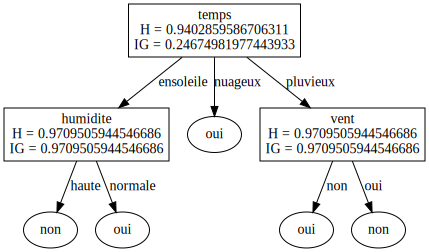

In [21]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz        import Source
    from IPython.display import display
    
    graph = Source(id3_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('il faut installer graphviz')

### I.2. CART

Ici, nous allons implémenter l'algorithme CART pour la classification avec des caractéristiques numériques. 
Nous allons utiliser le dataset "jouer (numériques)". 


In [23]:
# temperature, humidite, vent
X_njouer = np.array([
    [30, 85, 0],
    [27, 90, 1],
    [28, 78, 0],
    [21, 96, 0],
    [20, 80, 0],
    [18, 70, 1],
    [18, 65, 1],
    [22, 95, 0],
    [21, 70, 0],
    [24, 80, 0],
    [24, 70, 1],
    [22, 90, 1],
    [27, 75, 0],
    [22, 80, 1]
])

Y_njouer = Y_jouer 

len(X_njouer), len(Y_njouer)

(14, 14)

#### I.2.1. Index de diversité de Gini

Dans le cas de classement, CART utilise l'indexe de diversité Gini pour mesurer l'erreur de classification.
Un index de 0 représente la meilleure division; 

Etant donné : 
- $S$ liste des valeurs  
- $V$ ensemble des valeurs uniques de $S$  (vocabulaire)

L'index de diversité  $Gini(S)$ est calculée comme suit : 
$$Gini(S) = \sum\limits_{v \in V} p(v/S) (1-p(v/S)) = 1 - \sum\limits_{v \in V} p(v/S)^2 $$

In [25]:
# TODO: Gini
def Gini(S: np.ndarray) -> float:  
    V = np.unique(S)
    gini = 1
    for element in V :
      gini=gini-P(S,element)**2
      
    return gini 

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 0.4591836734693877
#---------------------------------------------------------------------

Gini(Y_njouer)

0.4591836734693877

#### I.2.2. Division d'un ensemble

**Rien à programmer ici**

Ici, nous essayons de diviser la liste des prédictions (classes) $Y$ selon une valeur donnée $v$ d'un attribut (caractéristique, colonne) $A$ sur deux listes :
- $Y_G$ : une liste contenant les éléments de $Y$ où $A > v$
- $Y_D$ : une liste contenant les éléments de $Y$ où $A \le v$


In [27]:
def diviser_CART(Y:np.ndarray, A:np.ndarray, v:float):
    msk = A > v
    return Y[msk], Y[~msk]

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array(['non', 'non', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui',
#         'oui', 'non'], dtype='<U3'),
#  array(['oui', 'non', 'oui'], dtype='<U3'))
#---------------------------------------------------------------------

diviser_CART(Y_njouer, X_njouer[:,0], 20)

(array(['non', 'non', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui',
        'oui', 'non'], dtype='<U3'),
 array(['oui', 'non', 'oui'], dtype='<U3'))

#### I.2.3. Diversité Gini de la division

Etant donné : 
- **Y** : une liste de prédictions
- **V** : les différentes valeurs de Y (les classes
- S_G, G_D : sous ensembles gauche et droit
- $|S| = |S_G| + |S_D|$

La diversité Gini de la division : 

$$Gini_{div}(S_G, S_D) = \frac{|S_G|}{|S|} Gini(S_G) + \frac{|S_D|}{|S|} Gini(S_D)$$


In [29]:
# TODO: Diversité gini de la division
def Gini_div(S_G: np.ndarray, S_D: np.ndarray) -> float:  
    S_len = float(len(S_G) + len(S_D)) 
    S_G_len=len(S_G)
    S_D_len=len(S_D)
    return (S_G_len/S_len)*Gini(S_G)+(S_D_len/S_len)*Gini(S_D)

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# 0.4588744588744589
#---------------------------------------------------------------------

S_G, S_D = diviser_CART(Y_njouer, X_njouer[:, 0], 20)
Gini_div(S_G, S_D)

0.4588744588744589

#### I.2.4. Choix de l'attribut et la valeur de division CART

L'algorithme
- Pour chaque ccaractéristique $X_j$ 
   - Pour chaque valeur $v$ appartennant aux valeurs uniques de $X_j$
       1. Diviser $Y$ en se basant sur la valeur $v$ et celles de $X_j$
       1. Calculer Gini de cette division 
       1. Garder l'indice **jj** de la caractéristique qui minimise Gini
       1. Garder Gini minimale **gini_jj**
       1. Garder la valeur de dévision **v_jj**
       

In [31]:
# TODO: Choix de l'attribut et la valeur de division CART
def choisir_division_CART(X: np.ndarray, Y: np.ndarray) -> Tuple[int, float, float]: 
    jj      = -1
    gini_jj =  1.0
    v_jj    = -1.0
    for j in range(len(X[0])):
      XJ=X[ : , j]
      for i in np.unique(XJ) :
        resultdiv_cart = diviser_CART(Y, XJ, i)
        new_gini_jj = Gini_div(resultdiv_cart[0], resultdiv_cart[1])
        if(new_gini_jj < gini_jj):
           gini_jj= new_gini_jj 
           jj=j
           v_jj = i
    
    return jj, gini_jj, v_jj

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (1, 0.3936507936507937, 80)
#---------------------------------------------------------------------

choisir_division_CART(X_njouer, Y_njouer)

(1, 0.3936507936507937, 80)

#### I.2.5. Arrêt de division CART

**Rien à programmer ici** 

On va utiliser la même fonction que celle de ID3. Mais, pour être consistant, on va seulement renomer la fonction et passer Gini à la place de l'entropie.

In [32]:
arreter_CART = arreter_ID3

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# ('oui', 'non', None)
#---------------------------------------------------------------------

Y_t1 = np.array(['oui', 'oui', 'oui'])
Y_t2 = np.array(['oui', 'non', 'non'])
arreter_CART(Y_t1, H(Y_t1), 2), \
arreter_CART(Y_t2, H(Y_t2), 4), \
arreter_CART(Y_t2, H(Y_t2), 2)

('oui', 'non', None)

#### I.2.6. Création de l'arbre

**Rien à programmer ici**

In [34]:
# Comme Noeud, mais il faut changer un peu, puisqu'on teste sur des 
# valeurs numériques aussi
# Le code sera plus utilisable si on crée une classe commune et on hérite
# Mais, je n'ai pas le temps pour tout ça (DEAL WITH IT)
class NoeudBin(object): 
    
    nbr = 0
    
    def __init__(self, num:int, val:int, gini:float, profondeur:int): 
        self.num    = num        # le numéro du caractéristique de dévision dans X
        self.val    = val        # la valeur du noeud
        self.gini   = gini       # le Gini de division
        self.pr     = profondeur # la profondeur du noeud
        self.fils   = []         # les fils ; un tableau de deux noeuds: S_G, S_D
        self.cls    = ''         # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = '    '     # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
         
        prefix = ' > '
        suffix = ''
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS SINON
        res  = ''
        res += indent + 'Si X[' + str(self.num) + '] ' + prefix + str(self.val) + suffix 
        res += ' Alors\n' + str(self.fils[0])
        res += indent + 'Sinon\n' + str(self.fils[1])
        return res
    
    # predire un échantillon
    def predire(self, x: List[float]): 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # sinon
        if x[self.num] > self.val:
            return self.fils[0].predire(x)
        return self.fils[1].predire(x)

    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(NoeudBin.nbr)
        NoeudBin.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        prefix = '] > '
        res = nid + '[label="X[' + str(self.num) + prefix + str(self.val) + '\\n'
        res += 'Gini = ' + str(self.gini) + '"];\n'
        vid_G, code_G = self.fils[0].graphviz()
        vid_D, code_D = self.fils[1].graphviz()
        
        res += code_G + code_D
        res += nid + ' -> ' + vid_G + ' [label="Vrai"];\n'
        res += nid + ' -> ' + vid_D + ' [label="Faux"];\n'
        return nid, res

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer_CART(X:np.ndarray, Y:np.ndarray, profondeur:int=0, nbr_min:int=0): 
    
    # Chercher le meilleur caractéristique de X pour diviser Y
    jj, gini_jj, v_jj = choisir_division_CART(X, Y)
    # Créer un noeud
    noeud = NoeudBin(jj, v_jj, gini_jj, profondeur)
    # Si l'entropie est 0 donc le noeud est terminal, élagage
    
    cls = arreter_CART(Y, gini_jj, nbr_min)
    if cls:
        noeud.cls = cls # la classe du noeud
        return noeud # retourner le noeud 
     
    
    # Sinon, si le noeud n'est pas terminal, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # création des deux fils
    
    msk = X[:, jj] > v_jj
    
    X_G = X[msk]
    Y_G = Y[msk]
    fils_G = entrainer_CART(X_G, Y_G, profondeur, nbr_min)
    X_D = X[~msk]
    Y_D = Y[~msk]
    fils_D = entrainer_CART(X_D, Y_D, profondeur, nbr_min)
    noeud.fils.append(fils_G)
    noeud.fils.append(fils_D)
    
    return noeud

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# Le Code
# Si X[1]  > 80 Alors
#     Si X[0]  > 22 Alors
#         Y est "non"
#     Sinon
#         Si X[0]  > 21 Alors
#             Y est "non"
#         Sinon
#             Y est "oui"
# Sinon
#     Si X[2]  > 0 Alors
#         Si X[1]  > 70 Alors
#             Y est "non"
#         Sinon
#             Si X[0]  > 18 Alors
#                 Y est "oui"
#             Sinon
#                 Y est "non"
#     Sinon
#         Y est "oui"
#---------------------------------------------------------------------

arbre_njouer = entrainer_CART(X_njouer, Y_njouer)

print('Le Code')
print(arbre_njouer)

Le Code
Si X[1]  > 80 Alors
    Si X[0]  > 22 Alors
        Y est "non"
    Sinon
        Si X[0]  > 21 Alors
            Y est "non"
        Sinon
            Y est "oui"
Sinon
    Si X[2]  > 0 Alors
        Si X[1]  > 70 Alors
            Y est "non"
        Sinon
            Si X[0]  > 18 Alors
                Y est "oui"
            Sinon
                Y est "non"
    Sinon
        Y est "oui"



#### I.2.7. Regrouper le tous

**Rien à programmer ici**

In [35]:
class CART(object): 
    
    def entrainer(self, X:np.ndarray, Y:np.ndarray, X_noms:List[str]=[], Y_nom:str='', nbr_min:int=0):
        self.arbre = entrainer_CART(X, Y, 0, nbr_min)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace('Y', Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace('X[' + str(i) + ']', X_noms[i])
        self.code   = code
        self.X_noms = X_noms
    
    def predire(self, X:np.ndarray): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res  = 'digraph Tree {\n'
        res += 'node [shape=box] ;'
        for i in range(len(self.X_noms)): 
            code = code.replace('X[' + str(i) + ']', self.X_noms[i])
        res += code
        res += '}'
        return res

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# Si humidite  > 80 Alors
#     Si temperature  > 22 Alors
#         jouer est "non"
#     Sinon
#         Si temperature  > 21 Alors
#             jouer est "non"
#         Sinon
#             jouer est "oui"
# Sinon
#     Si vent  > 0 Alors
#         Si humidite  > 70 Alors
#             jouer est "non"
#         Sinon
#             Si temperature  > 18 Alors
#                 jouer est "oui"
#             Sinon
#                 jouer est "non"
#     Sinon
#         jouer est "oui"
#---------------------------------------------------------------------

cart_classifieur = CART()
cart_classifieur.entrainer(X_njouer, Y_njouer, X_noms=['temperature', 'humidite', 'vent'], Y_nom='jouer')
print(cart_classifieur.code)

Si humidite  > 80 Alors
    Si temperature  > 22 Alors
        jouer est "non"
    Sinon
        Si temperature  > 21 Alors
            jouer est "non"
        Sinon
            jouer est "oui"
Sinon
    Si vent  > 0 Alors
        Si humidite  > 70 Alors
            jouer est "non"
        Sinon
            Si temperature  > 18 Alors
                jouer est "oui"
            Sinon
                jouer est "non"
    Sinon
        jouer est "oui"



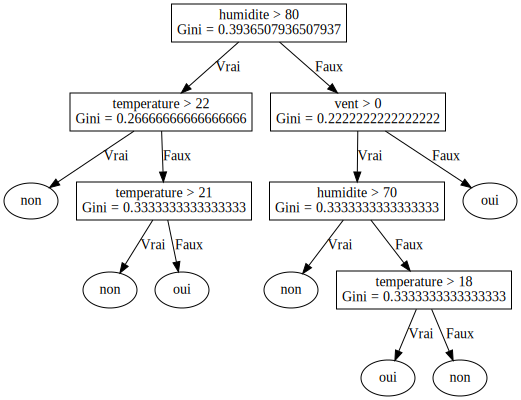

In [36]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(cart_classifieur.graphviz())
    
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print('il faut installer graphviz')

## II. Application et analyse

Nous allons utiliser le dataset [Cars Data](https://www.kaggle.com/abineshkumark/carsdata) pour classer les voitures en trois classes : US., Euroupe. ou Japan. 
Dans cette section, nous allons discuter les paramètres des arbres de décision et les forêts aléatoires implémentés dans des outils connus (dans ce cas, scikit-learn).

In [38]:
# Lecture du dataset
cars_data = pd.read_csv('data/cars.csv', skipinitialspace=True)
# On a remarqué que le type de cette caractéristique n'est pas bien détecté
# cars_data['cubicinches'] = pd.to_numeric(cars_data['cubicinches'])
# supprimer les valeurs absentes 
cars_data.dropna(inplace=True)
# Yay! We did it! Voici les premières lignes du dataset
cars_data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [39]:
cars_data.dtypes

mpg            float64
cylinders        int64
cubicinches    float64
hp               int64
weightlbs      float64
time-to-60       int64
year             int64
brand           object
dtype: object

In [40]:
from sklearn.model_selection import train_test_split

X_cars = cars_data.values[:, :-1]
Y_cars = cars_data.values[:,  -1]

X_cars_train, X_cars_test, Y_cars_train, Y_cars_test = train_test_split(X_cars, 
                                                                        Y_cars, 
                                                                        test_size=0.2, 
                                                                        random_state=0) 

X_cars_train.shape, X_cars_test.shape

((204, 7), (52, 7))

### II.1. Arbres de décision

Dans l'implémentation Scikit-learn des arbres de décision (**DecisionTreeClassifier**), les caractéristiques sont permutées d'une façon aléatoire à chaque division. 
Ceci rend l'arbre non déterministe. 
Pour arrêter ça, la proporiété **random_state=0** est utilisée.

#### II.1.1. Critère de choix des caractéristiques

Nous avons entraîné deux arbres de décision CART avec les critères de division : 
1. Entropy
1. Gini

Dans scikit-learn, il n'existe que CART (les arbres sont binaires). 
Mais le critère de division peut être choisi.

In [41]:
from   sklearn.tree    import DecisionTreeClassifier
from   sklearn.metrics import f1_score
from   sklearn         import tree
import timeit

Xchoix_train = X_cars_train
Ychoix_train = Y_cars_train
Xchoix_test  = X_cars_test
Ychoix_test  = Y_cars_test
fnames       = cars_data.columns

#Xchoix_train = X_njouer[4:, :]
#Ychoix_train = Y_njouer[4:   ]
#Xchoix_test  = X_njouer[:4, :]
#Ychoix_test  = Y_njouer[:4   ]
#fnames       = ['temperature', 'humidite', 'vent']


gini_stats          = []
entropy_stats       = []
gini_classifieur    = DecisionTreeClassifier(criterion='gini'   , random_state=0)
entropy_classifieur = DecisionTreeClassifier(criterion='entropy', random_state=0)

# ============ GINI ====================
# ............ Entraînement ............
temps_debut = timeit.default_timer()
gini_classifieur.fit(Xchoix_train, Ychoix_train)
gini_stats.append(timeit.default_timer() - temps_debut)
# ..... Evaluation entrainement ........
gini_stats.append(f1_score(Ychoix_train, gini_classifieur.predict(Xchoix_train), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = gini_classifieur.predict(Xchoix_test)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
gini_stats.append(f1_score(Ychoix_test, Ychoix_pred, average='micro'))

# =========== Entropy ==================
# ............ Entraînement ............
temps_debut = timeit.default_timer()
entropy_classifieur.fit(Xchoix_train, Ychoix_train)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ..... Evaluation entrainement ........
entropy_stats.append(f1_score(Ychoix_train, entropy_classifieur.predict(Xchoix_train), average='micro'))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = entropy_classifieur.predict(Xchoix_test)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
entropy_stats.append(f1_score(Ychoix_test, Ychoix_pred, average='micro'))

print('Fin')

Fin


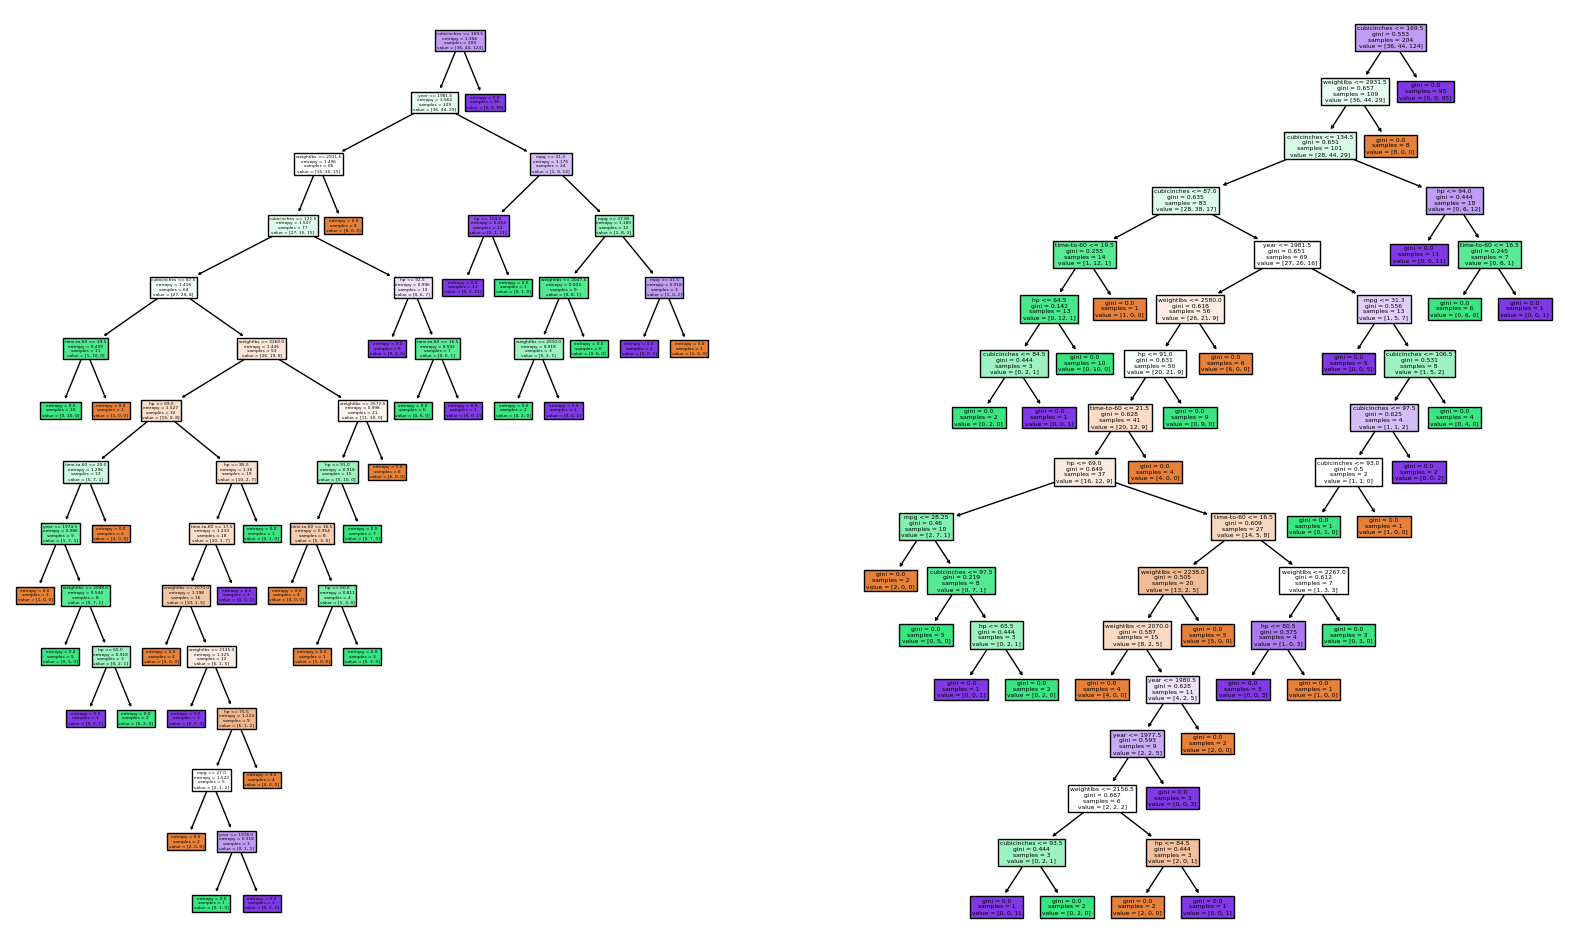

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth (20)
fig.set_figheight(12)
tree.plot_tree(entropy_classifieur, ax=ax1, feature_names=fnames, filled=True)
tree.plot_tree(gini_classifieur   , ax=ax2, feature_names=fnames, filled=True)
plt.show()

In [44]:
pd.DataFrame({
    'Criteres' : ['Temps Entrainement', 'F1 Entrainement', 'Temps Test', 'F1 Test'],
    'Entropie' : entropy_stats,
    'Gini'     : gini_stats
})

,Criteres,Entropie,Gini
0,Temps Entrainement,0.006652,0.003177
1,F1 Entrainement,1.000000,1.000000
2,Temps Test,0.000351,0.000362
3,F1 Test,0.826923,0.788462


**TODO : Analyser les résultats**
- Que remarquez-vous concernant la structure des deux arbres : ENTOPY (à gauche) et GINI (à droit) ? La structure veut dire : la profendeur, le nombre des feuilles, la position des feuilles (près de la racine ou non), etc.
- Justifier le temps d'entraînement et de test en se basant sur les deux algorithmes et les deux structures discutées.

**Réponse**
- On remarque qu'ils ont resque la meme profendeur (l'arbre **GINI** est un peu plus profand que celui de **ENTOPY**  )avec le meme nombre de feuilles pour les deux (32 feuilles) , on remarque encore que les feuilles sont plus  proches de la racine pour l'arbre **GINI** que l'arbre **ENTOPY**, en moyen des profendeur Des branches de l'arbre GINI est supérieure a celle de l'arbre de l'ENTROPY
- On remarque que **ENTROPY** prend plus de temps pour l'entrainement   ,car l'algorithme de construction d'un arbre de décision **ENTROPY** est plus complexe que l'algorithme basé  **GINI** (Cela est dû au fait que le critère ENTROPY nécessite des calculs PLUS complexes que GINI.), ce qui peut entraîner des temps d'entraînement  longs pour l'algorithme **ENTROPY**. Et le faite que la profendeur et la structure des deux arbres est presque la meme , lors du test le parcours en profendeur (des deux arbres ) a travers les branches de l'arbre est presque la meme pour les deux ce qui donne un temps de test  presque le meme pour les deux.

#### II.1.2. Profondeur maximale de l'arbre

Pour chaque profondeur, nous entraînons un modèle et nous mesurons sa convergence et sa performance en terme du score F1. 


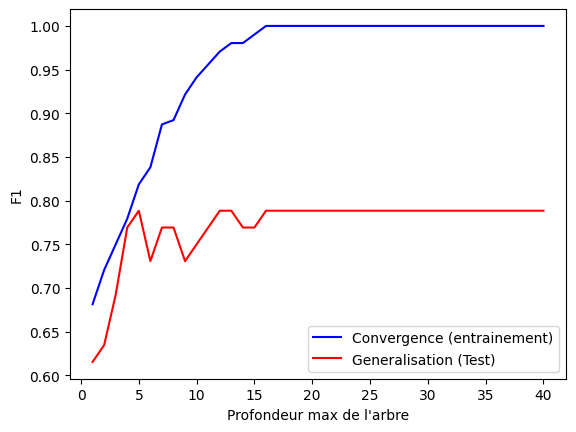

In [45]:
MAX_PROF     = 40
MAX_PROF_lst = range(1, MAX_PROF+1, 1)

f1_train_pm  = []
f1_test_pm   = []
for max_prof in MAX_PROF_lst:
    classifieur = DecisionTreeClassifier(random_state=0, max_depth=max_prof)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_pm.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average='micro'))
    f1_test_pm.append (f1_score(Y_cars_test , classifieur.predict(X_cars_test) , average='micro'))

plt.plot(MAX_PROF_lst, f1_train_pm, color='blue', label='Convergence (entrainement)')
plt.plot(MAX_PROF_lst, f1_test_pm , color='red' , label='Generalisation (Test)'     )
plt.ylabel('F1')
plt.xlabel('Profondeur max de l\'arbre')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO : Analyser les résultats**
- Que remarquez-vous ?
- Est-ce que plus de profondeur veut dire le modèle va généraliser mieux ?
- Justifier

**Réponse**
- En augmentant la profondeur maximale de l'arbre de décision, on observe généralement une augmentation  du score F1 de la convergence (d'entraînement ). Cependant, il y a un point où la  convergence (entraînement) se stabilise à une certaine valeur(1.0) et n'augmente plus même si la profondeur maximale continue d'augmenter. pour le score F1 de la  **GENERALISATION** Dans un premier temps, l'augmentation de la profondeur maximale  améliore la généralisation du modèle en lui permettant de capturer des relations plus complexes dans les données.et puis la generalisation du modéle se stabilise.
- Non , l'augmentation de la profondeur(plus de profendeur) d'un arbre de décision ne garantit pas toujours que le modèle va généraliser mieux
-  Plus de profondeur  dans l'arbre de décision peut rendre le modèle plus complexe et précis sur les données d'entraînement, mais peut également entraîner une suradaptation (sur apprentissage) aux données d'entraînement et une mauvaise performance de prédiction sur de nouvelles données car l'arbre sera une replication des données d'entrainement. Il est important de trouver un équilibre entre la complexité du modèle et sa capacité à généraliser en choisissant une profondeur optimale pour l'arbre de décision.

#### II.1.3. Observations minimales dans les feuilles

Pour chaque nombre des observations minimales dans les feuilles, nous entraînons un modèle et nous mesurons sa convergence et sa performance en terme du score F1. 

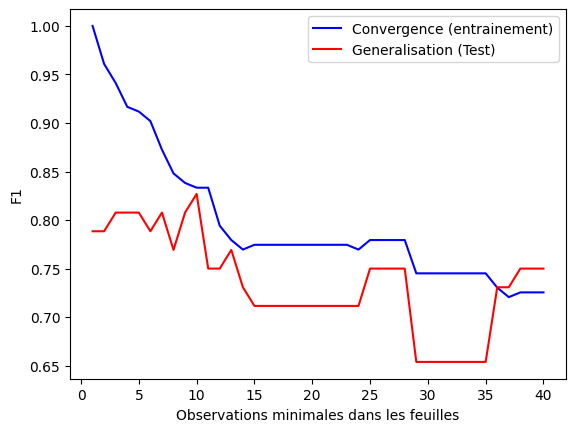

In [46]:
MIN_FEUILLE     = 40
MIN_FEUILLE_lst = range(1, MIN_FEUILLE+1, 1)

f1_train_mf     = []
f1_test_mf      = []
for min_feuille in MIN_FEUILLE_lst:
    classifieur = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_feuille)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_mf.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average='micro'))
    f1_test_mf.append (f1_score(Y_cars_test , classifieur.predict(X_cars_test) , average='micro'))

plt.plot(MIN_FEUILLE_lst, f1_train_mf, color='blue', label='Convergence (entrainement)')
plt.plot(MIN_FEUILLE_lst, f1_test_mf , color='red' , label='Generalisation (Test)'     )
plt.ylabel('F1')
plt.xlabel('Observations minimales dans les feuilles')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO : Analyser les résultats**
- Que remarquez-vous ?
- Justifier pourquoi la performance se diminue (en indiquant si ce critère d'arrêt garantie un apprentissage normale ou peut causer un sur-apprentissage ou sous-apprentissage)

**Réponse**
- On remarque que le score F1 de la convergence (entrainement) se diminue en augmentant l'observations minimales dans les feuilles , et que l'augmentation de cette derniére a une influence sur le score F1 de la  généralisation du modèle. Plus précisément, pour de petites valeurs, cela  n'a pas  d'impact significatif sur la généralisation et elle est bonne, mais pour de grandes valeurs, l'augmentation  d'observations minimales dans les feuilles entraîne une diminution de la généralisation , en generale plus ce facteur augmente pluse le score F1 se diminue.
- **la performance se  diminue à mesure que ce nombre ( observations minimales dans les feuilles ) augmente**,car des valeurs élevées pour ce critère d'arrêt peuvent conduire à un **sous-apprentissage**, car le modèle aura des feuilles avec moins d'informations, le modèle peut devenir trop simple et ne pas être en mesure de capturer la complexité des données. encore  le modèle ne pourra pas généraliser correctement sur des données qu'il n'a pas déja vu ce qui diminue ses performances .
 **Dans le cas ou  le nombre d'observations minimales dans les feuilles est trop faible**, le modèle peut **sur-apprendre**( sur apprentissage) les données d'entraînement**(sur-apprentissage)**, c'est-à-dire qu'il peut trop bien s'ajuster aux données d'entraînement et perdre la capacité de généraliser sur de nouvelles données.

### II.2. Forêts aléatoires

#### II.2.1. Nombre des arbres

Pour chaque nombre des arbres dans le forêt, nous entraînons un modèle et nous mesurons sa convergence et sa performance en terme du score F1. 

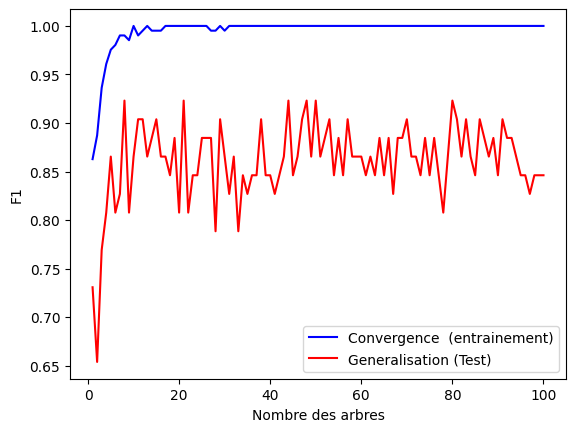

In [47]:
from sklearn.ensemble import RandomForestClassifier

MAX_ARBRE     = 100
MAX_ARBRE_lst = range(1, MAX_ARBRE+1, 1)

f1_train_nbarbres = []
f1_test_nbarbres  = []
for max_arbres in MAX_ARBRE_lst:
    classifieur = RandomForestClassifier(n_estimators=max_arbres)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_nbarbres.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average='micro'))
    f1_test_nbarbres.append (f1_score(Y_cars_test , classifieur.predict(X_cars_test) , average='micro'))

plt.plot(MAX_ARBRE_lst, f1_train_nbarbres, color='blue', label='Convergence  (entrainement)')
plt.plot(MAX_ARBRE_lst, f1_test_nbarbres , color='red' , label='Generalisation (Test)'      )
plt.ylabel('F1')
plt.xlabel('Nombre des arbres')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO : Analyser les résultats**
- Que remarquez-vous ? (convergence et généralisation)
- Est-ce que plus d'arbre PEUT améliorer la performance ? Expliquer.

**Réponse**
- On remarque que le score F1 de la convergence augmente en augmentant le nombres d'arbres , et se stabilise a partir d'un certain  nombre d'arbres a un seuil(1.00), de meme pour le score F1 de la generalisation du modéle qui augmente en augmentant le nombres d'arbres et se stablise a partir d'un certain  nombre d'arbres a un seuil(0.875),Avec des turbulances de tandance ascendantes pour le scre F1 de GENERALISATION
- **Oui , plus d'arbre vas améliorer la performance du modéle(score F1 ) sue les données d'entrainement, Mais sur les données de test non** ,  car l'ajout de plus d'arbres peut entraîner une sur-ajustement des données d'entraînement(sur apprentissage), ce qui réduit la capacité de généralisation du modèle( ce qui explique les perturbations sur le changement du score  dans les résultats ) .pour cela il faut trouver un nombre optimal d'arbres (on peux utiliser quelques methodes pour trouver ce nombre)

#### II.2.2. Profondeur maximale des arbres

Pour chaque profondeur, nous entraînons un forêt et nous mesurons sa convergence et sa performance en terme du score F1. 
Nous comparons les résultats avec les arbres équivalents (avec la même profondeur).


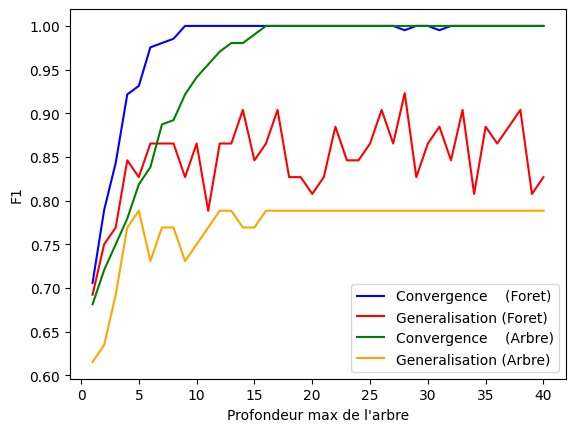

In [48]:
f1_train_pm_foret = []
f1_test_pm_foret  = []
for max_prof in MAX_PROF_lst:
    classifieur = RandomForestClassifier(n_estimators=40, max_depth=max_prof)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_pm_foret.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average='micro'))
    f1_test_pm_foret.append (f1_score(Y_cars_test , classifieur.predict(X_cars_test) , average='micro'))

plt.plot(MAX_PROF_lst, f1_train_pm_foret, color='blue'  , label='Convergence    (Foret)')
plt.plot(MAX_PROF_lst, f1_test_pm_foret , color='red'   , label='Generalisation (Foret)')
plt.plot(MAX_PROF_lst, f1_train_pm      , color='green' , label='Convergence    (Arbre)')
plt.plot(MAX_PROF_lst, f1_test_pm       , color='orange', label='Generalisation (Arbre)')
plt.ylabel('F1')
plt.xlabel('Profondeur max de l\'arbre')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO : Analyser les résultats**
- Comparer la convergence des forêts et des arbres en terme de la profondeur maximale
- Comparer la généralisation des forêts et des arbres en terme de la profondeur maximale
- Justifier ces résultats (en indiquant pourquoi nous avons des oscillations dans F1 test des forêts)

**Réponse**
- Le score F1 des   forets converge plus rapidement que l'arbre en fonction de la profendeur maximale(ie en augmentant la profendeur max)
- En fonction de la profendeur maximale , les forêts  généralise mieux  que l'arbre et que le score F1 de generalisation des forets atteint plus rapidement un bon score (seuil) que  pour l'arbre .avec des oscillations dans F1 test des forêts.
- **En termes de convergence**, les forêts toires convergent plus rapidement que l'arbres de décision. Ceci est dû au fait que les forêts  combinent plusieurs arbres de décision, chacun apprenant une partie des données, ce qui conduit à une convergence plus rapide.**En terme de generalisation**, Les forêts  sont plus performantes que l'arbre de décision en termes de généralisation sur les données de test, car elles sont composées de plusieurs arbres de décision qui apprennent différentes parties des données, ce qui réduit le risque de sur-apprentissage et améliore la capacité de généralisation.en plus les forets utilisent des technique de randomisation pour créer les sous-ensemble de données (aléatoires)ce qui réduit le risque de sur apprentissage et augmente la generalisation. et que c'est logique que les foret donne des resultats meilleure que les resultats de l'arbre. **Les oscillations dans les scores test  F1 des forêts**  indique une mauvaise generalisation , car chacun des arbres sur apprend( sur apprentissage) vu que le bootstrap est le meme entre les arbres , et que chaque arbre de la foret sur apprend sur son données d'entrainement, ce qui implique un sur apprentissage de la foret ,ce qui peu causer des oscillations

#### II.2.3. Observations minimales dans les feuilles

Pour chaque nombre minimale des observations dans les feuilles, nous entraînons un forêt et nous mesurons sa convergence et sa performance en terme du score F1. 
Nous comparons les résultats avec les arbres équivalents (avec le même nombre des observations minimales).

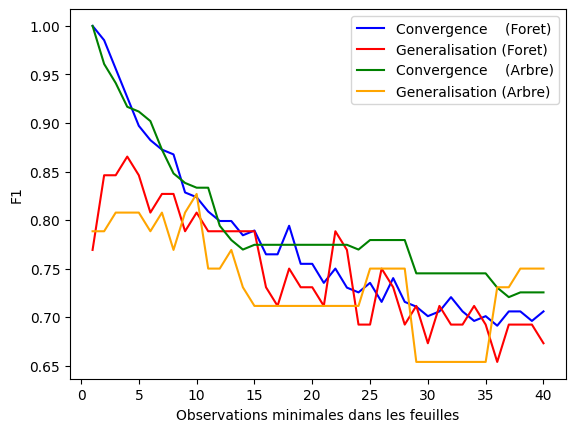

In [49]:
f1_train_mf_foret = []
f1_test_mf_foret  = []
for min_feuille in MIN_FEUILLE_lst:
    classifieur = RandomForestClassifier(n_estimators=40, min_samples_leaf=min_feuille)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_mf_foret.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average='micro'))
    f1_test_mf_foret.append (f1_score(Y_cars_test , classifieur.predict(X_cars_test) , average='micro'))

plt.plot(MIN_FEUILLE_lst, f1_train_mf_foret, color='blue'  , label='Convergence    (Foret)')
plt.plot(MIN_FEUILLE_lst, f1_test_mf_foret , color='red'   , label='Generalisation (Foret)')
plt.plot(MIN_FEUILLE_lst, f1_train_mf      , color='green' , label='Convergence    (Arbre)')
plt.plot(MIN_FEUILLE_lst, f1_test_mf       , color='orange', label='Generalisation (Arbre)')
plt.ylabel('F1')
plt.xlabel('Observations minimales dans les feuilles')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO : Analyser les résultats**
- Comparer la performance (convergence et généralisation) des arbres et des forêts en terme du noombre des observations dans les feuilles
- Justifier 

**Réponse**
- on remarque presque la meme décroissance pour les deux et que ,  **En termes de convergence**, on observe que les forêts  convergent légèrement plus rapidement que les arbres de décision pour les faibles valeurs de nombre minimum d'observations dans les feuilles. Cependant, pour les valeurs plus élevées, les arbres de décision ont une convergence plus rapide que les forêts .**En ce qui concerne la généralisation**, les forêts  ont généralement de meilleures performances que les arbres de décision, quelle que soit la valeur du nombre minimum d'observations dans les feuilles(une grande difference pour des grandes valeurs  du nombre minimum d'observations dans les feuilles et petite difference pour des petites valeurs de ce dernier) .

- On remarque le meme effet (decroissance) sur les deux , car de la même manière que le nombre minimum d'observations dans les feuilles peut entraîner un sous-apprentissage des arbres de décision, ce facteur peut également causer un sous-apprentissage des forêts aléatoires. En effet, les forêts aléatoires sont composées de plusieurs arbres qui effectuent des prédictions et dont les erreurs sont ensuite moyennées. Par conséquent, si le nombre minimum d'observations dans les feuilles conduit à une performance insuffisante des arbres individuels, cela se répercutera( la meme chose) sur la performance globale de la forêt aléatoire.

#### II.2.4. Taille d'un Bootstrap

Ici, on définit un pourcentage de la taille des Bootstrap par rapport la taille initiale du dataset. Pour chaque pourcentage, on entraîne un forêt et on test sa performance (convergence et généralisation) en utilisant la mesure F1.

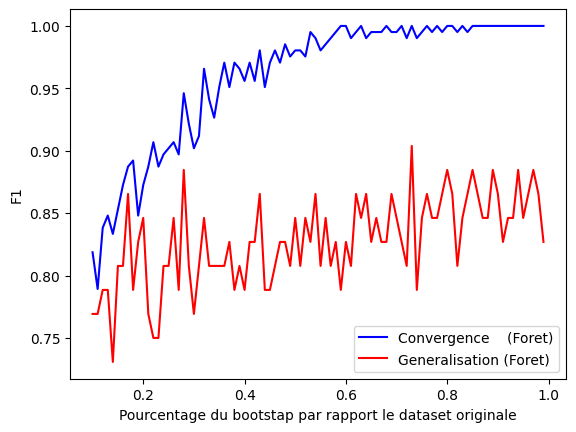

In [50]:
POUR_OBS_lst = np.arange(0.1, 1, 0.01)

f1_train_ech = []
f1_test_ech  = []
for pour_obs in POUR_OBS_lst:
    classifieur = RandomForestClassifier(n_estimators=40, max_samples=pour_obs)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_ech.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average='micro'))
    f1_test_ech.append (f1_score(Y_cars_test , classifieur.predict(X_cars_test) , average='micro'))

plt.plot(POUR_OBS_lst, f1_train_ech, color='blue', label='Convergence    (Foret)')
plt.plot(POUR_OBS_lst, f1_test_ech , color='red' , label='Generalisation (Foret)')
plt.ylabel('F1')
plt.xlabel('Pourcentage du bootstap par rapport le dataset originale')
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

**TODO : Analyser les résultats**
- Que remarquez-vous ?
- Quelle est la raison pour laquelle la performance n'augmente pas d'une manière lisse ?

**Réponse**
- **Pour le score F1 de la  convergence :** on remarque une augmentation de la convergence avec l'augmentation du pourcentage de bootstrap,et puis converge à un certain pourcentage de bootstrap mais on observe des petites oscillations. **Pour le score F1 de la  generalisation :** la generalisation augmente  avec l'augmentation du pourcentage de bootstrap, mais on observe des petites oscillations .et qu'elle se stabilise a une valeur maximale(les environs de 0.86)  pour un pourcentage de taille des Bootstrap d'environ 60 à 70%.
-  la perfermonce n'augmente pas d'une façon lisse car  elle  dépend de la variabilité des échantillons d'entraînement générés par le Bootstrap. Les échantillons peuvent contenir des exemples qui sont très similaires ou très différents, ce qui peut affecter la performance de la forêt aléatoire. De plus, la taille du Bootstrap peut influencer la complexité de la forêt, ce qui peut également affecter la performance. ce qui donne une irrégularités de la performance (augmentation non lisse).Autrement dit l'utilisation d'un bootstrap croissant dans l'apprentissage des arbres de décision ne garantit pas nécessairement l'utilisation d'un ensemble de données plus large et diversifié. En effet, certains individus peuvent être sélectionnés plusieurs fois par plusieurs arbres, tandis que d'autres peuvent être marginalisés, ce qui peut conduire à des erreurs de classification. Toutefois, un bootstrap suffisamment élevé permettrait aux arbres de s'entraîner sur un ensemble de données plus large, ce qui pourrait améliorer leur apprentissage sans pour autant garantir une meilleure généralisation.

In [1]:
'FIN TP'

'FIN TP'